In [2]:
import numpy as np;from scipy import signal;from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py;import json
import matplotlib.pyplot as plt;import matplotlib.mlab as mlab 
import readligo as rl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load LIGO data.

In [3]:
eventname = 'GW150914' 
plottype = "png"

# Read the event properties from a local json file
fnjson = "BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)

# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal

try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
except:
    print("Cannot find data files!")

In [4]:
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

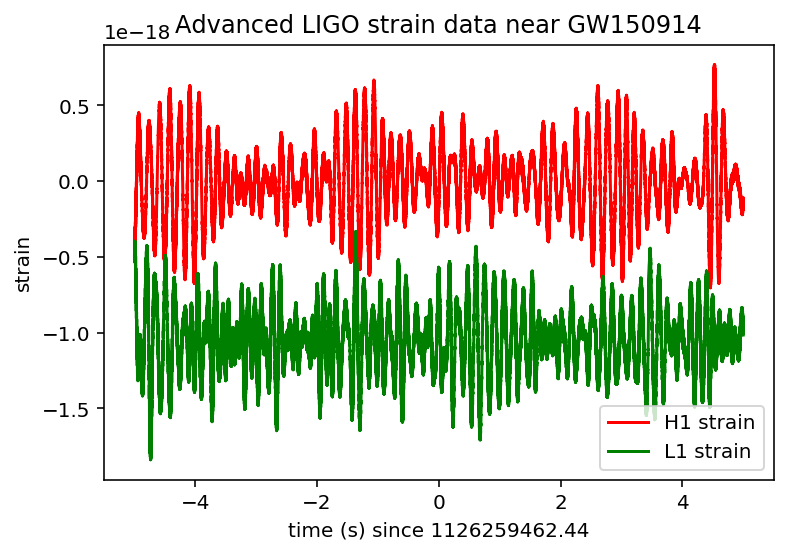

In [5]:
# plot +- deltat seconds around the event:
deltat = 5
# index into the strain time series for this time interval:
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat)) 
plt.figure()
plt.plot(time[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
plt.plot(time[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
plt.xlabel('time (s) since '+str(tevent));plt.ylabel('strain')
plt.legend(loc='lower right');plt.title('Advanced LIGO strain data near '+eventname)
plt.show()

## Amplitude Spectral Density

In [21]:
# Max and min frequncies to be plotted for frequency domain representations of data
f_range = [20,2000]

In [8]:
# Compute FT of windowed strain data
l = strain_H1.size
tukey = signal.tukey(l, alpha=1./8)# Tukey window
H1_ft = dt*np.fft.rfft(strain_H1*tukey)
L1_ft = dt*np.fft.rfft(strain_L1*tukey)
freqs = np.fft.rfftfreq(l,d=dt)

In [72]:
# Hamming window
hamming = np.hamming(l) 

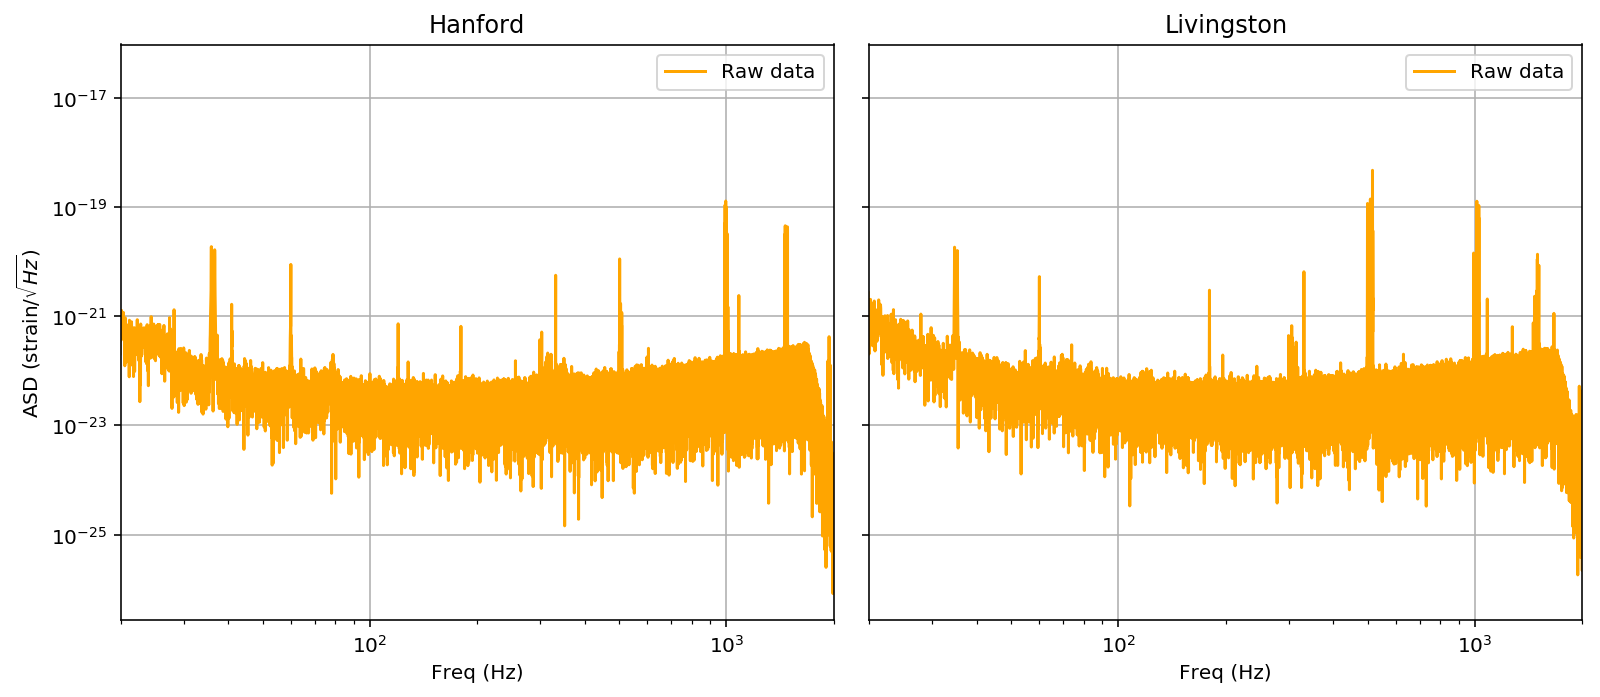

In [25]:
fig, ax = plt.subplots(1, 2,sharey=True,figsize=(11,5))
ax[0].loglog(freqs,abs(H1_ft), 'orange',label = "Raw data")
ax[0].set_title("Hanford");ax[0].set_xlabel('Freq (Hz)');ax[0].grid();ax[0].legend();ax[0].set_xlim(f_range)

ax[1].loglog(freqs,abs(L1_ft), 'orange',label = "Raw data")
ax[1].set_title("Livingston");ax[1].set_xlabel('Freq (Hz)');ax[1].grid();ax[1].legend();ax[1].set_xlim(f_range)

plt.tight_layout()
ax[0].set_ylabel('ASD (strain/$\sqrt{Hz}$)')
plt.show()

$\rightarrow$Noise is reduced by applying Welch's method (a standard averaging technique) on the data

In [26]:
# Compute PSD by Welch's method
H1_f,H1_psd = signal.welch(strain_H1,fs,nperseg = 2**int(np.log2(l/8)))
L1_f,L1_psd = signal.welch(strain_L1,fs,nperseg = 2**int(np.log2(l/8)))

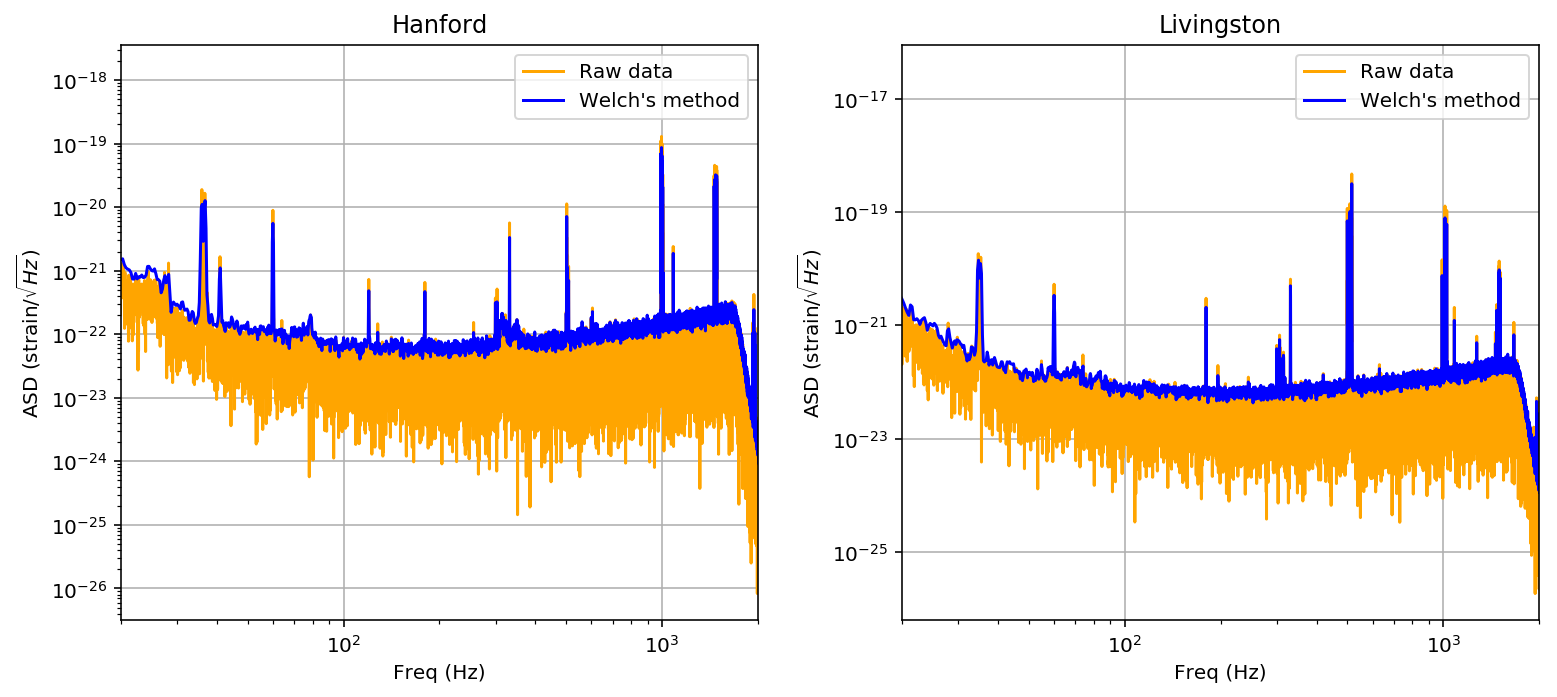

In [33]:
fig, ax = plt.subplots(1, 2,figsize=(11,5))
ax[0].loglog(freqs,abs(H1_ft), color ='orange',label = "Raw data")
ax[0].loglog(H1_f,np.sqrt(2*l*H1_psd/fs), color = 'b',label = "Welch's method")
ax[0].set_title("Hanford");ax[0].set_xlabel('Freq (Hz)');ax[0].grid();ax[0].legend();ax[0].set_xlim(f_range)

ax[1].loglog(freqs,abs(L1_ft), color = 'orange',label = "Raw data")
ax[1].loglog(H1_f,np.sqrt(2*l*L1_psd/fs), color = 'b',label = "Welch's method")
ax[1].set_title("Livingston");ax[1].set_xlabel('Freq (Hz)');ax[1].grid();ax[1].legend();ax[1].set_xlim(f_range)


ax[0].set_ylabel('ASD (strain/$\sqrt{Hz}$)')
ax[1].set_ylabel('ASD (strain/$\sqrt{Hz}$)')
plt.tight_layout()
plt.show()

# Noise model and Data Whitening

The strain data is "whitened" - (divided by the noise amplitude spectrum model, in the fourier domain). This suppresses the extra noise at low frequencies and at the spectral lines, to better resolve the weak signals in the most sensitive band.

$\rightarrow$ The resulting time series is no longer in units of strain; now in units of "sigmas" away from the mean noise.

In [29]:
# Noise model
H1_noise_amplitude = interp1d(H1_f, np.sqrt(2*l*H1_psd/fs))
L1_noise_amplitude = interp1d(L1_f, np.sqrt(2*l*L1_psd/fs))

In [30]:
# "Whiten" the data by dividing by the noise amplitude
H1_ft_wh = H1_ft/H1_noise_amplitude(freqs)
L1_ft_wh = L1_ft/L1_noise_amplitude(freqs)

# Go back to the time domain
H1_strain_wh = dt*np.fft.irfft(H1_ft_wh,n=l)
L1_strain_wh = dt*np.fft.irfft(L1_ft_wh,n=l)

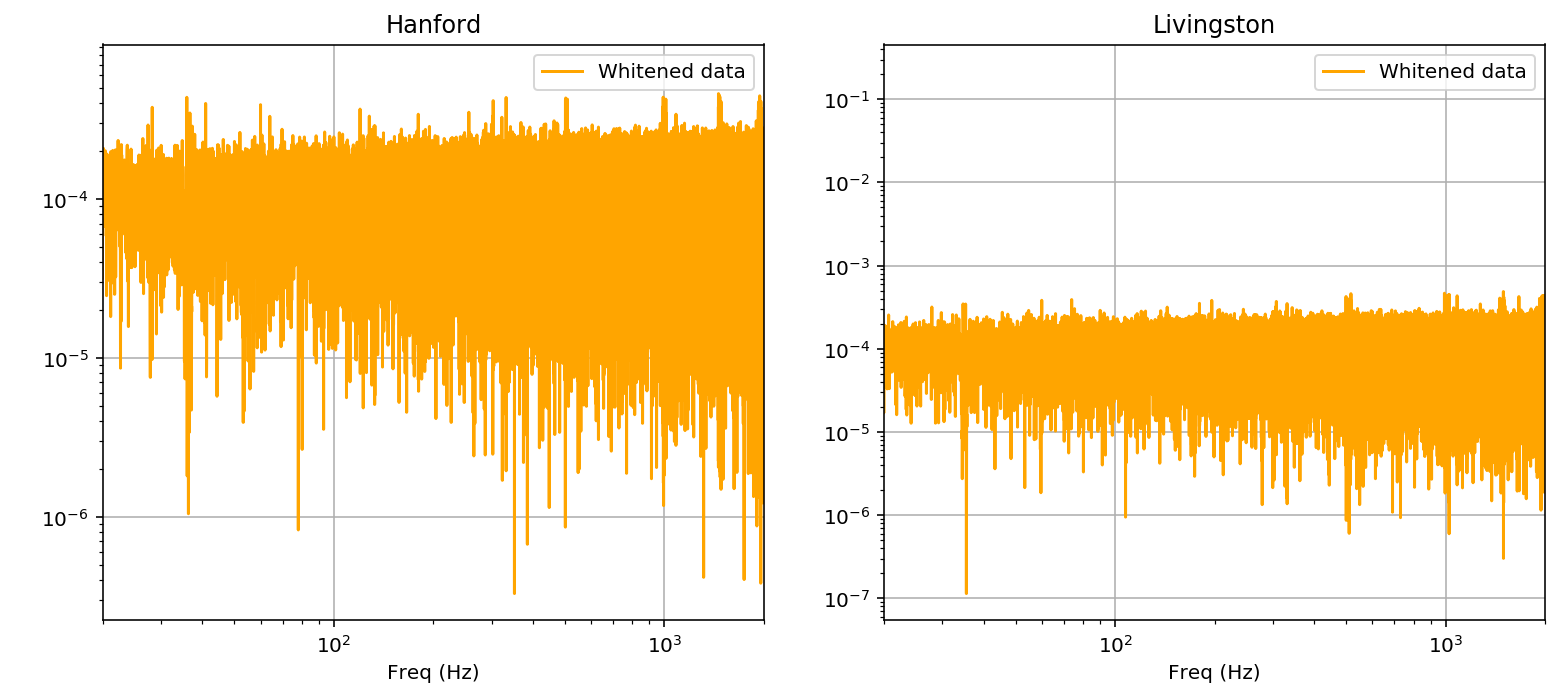

In [45]:
fig, ax = plt.subplots(1, 2,figsize=(11,5))
ax[0].loglog(freqs,dt*abs(H1_ft_wh), color ='orange',label = "Whitened data")
ax[0].set_title("Hanford");ax[0].set_xlabel('Freq (Hz)');ax[0].set_ylabel(' ')
ax[0].grid();ax[0].legend();ax[0].set_xlim(f_range)

ax[1].loglog(freqs,dt*abs(L1_ft_wh), color = 'orange',label = "Whitened data")
ax[1].set_title("Livingston");ax[1].set_xlabel('Freq (Hz)');ax[1].set_ylabel(' ')
ax[1].grid();ax[1].legend();ax[1].set_xlim(f_range)

plt.tight_layout()
plt.show()

In [ ]:
# Plot the whitened data in the time domain
plt.figure()
plt.plot(time-tevent,strain_wh,color='r')
plt.xlabel("time");plt.ylabel("Whitened strain (units of noise stdev)");plt.xlabel("Time (s)")
plt.grid();plt.show()

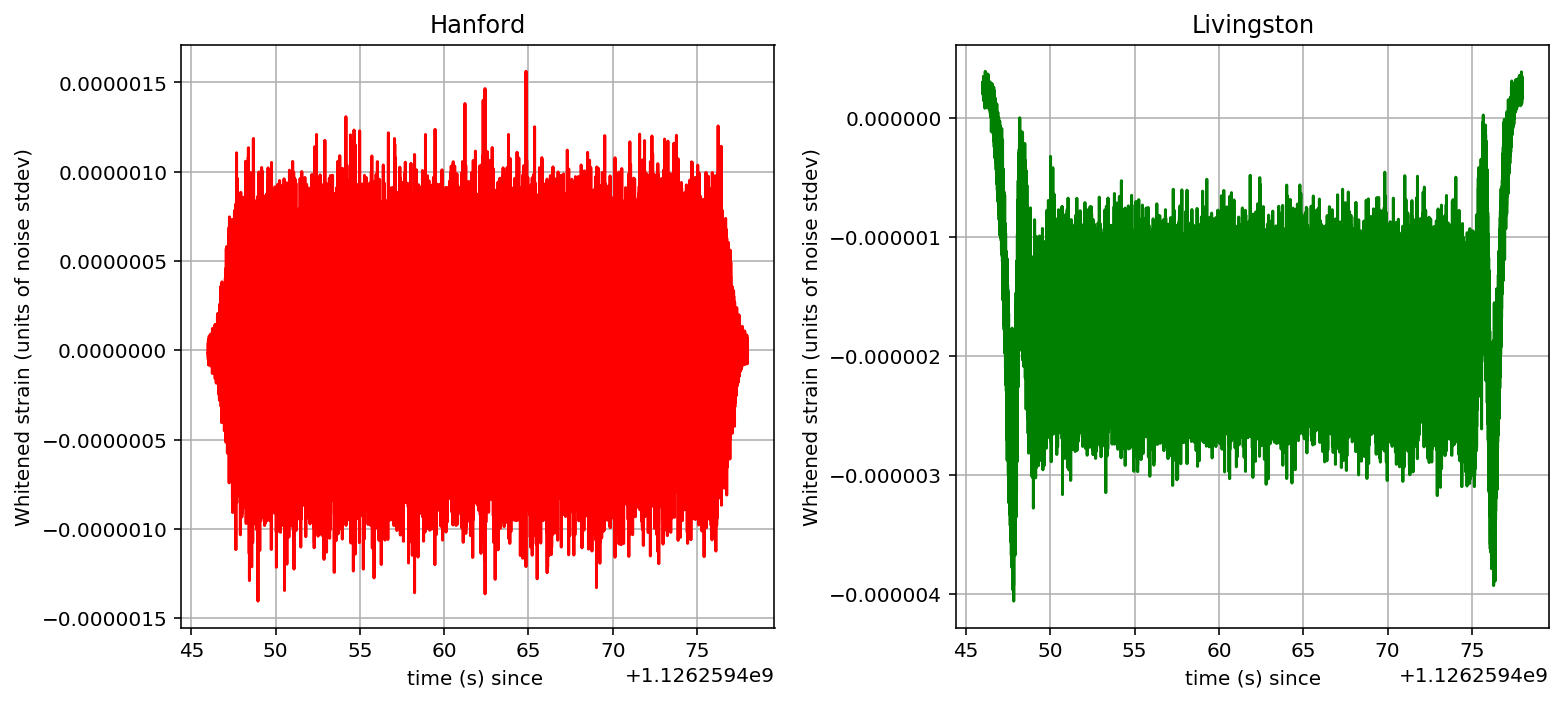

In [70]:
fig, ax = plt.subplots(1, 2,figsize=(11,5))

ax[0].plot(time,H1_strain_wh,color='r')
ax[0].set_title("Hanford");ax[0].set_xlabel('time (s) since ');ax[0].set_ylabel("Whitened strain (units of noise stdev)")
ax[0].grid();ax[0].set_xlim(None)

ax[1].plot(time,L1_strain_wh,color='g')
ax[1].set_title("Livingston");ax[1].set_xlabel('time (s) since');ax[1].set_ylabel("Whitened strain (units of noise stdev)")
ax[1].grid();ax[1].set_xlim(None)

plt.tight_layout()
plt.show()

## Bandpass Filter:

Now the signal is not quite yet visible because of low and high frequency noise in regions far outside that of interest.

$\rightarrow$ Apply a Bandpass filter to the remaining signal

$\rightarrow$  $4^{th}$ order Butterworth filter

$\rightarrow$ Low frequency cutoff = 20 Hz

$\rightarrow$ High frequency cutoff = 300 Hz

In [44]:
# Use almost the same bandpass filter as the ligo tutorial!
bb, ab = butter(4, [20*2./fs, fband[1]*2./fs], btype='band')
normalization = np.sqrt((fband[1]-fband[0])/(fs/2))

H1_strain_wh_bd = filtfilt(bb, ab, H1_strain_wh) / normalization
L1_strain_wh_bd = filtfilt(bb, ab, L1_strain_wh) / normalization

/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


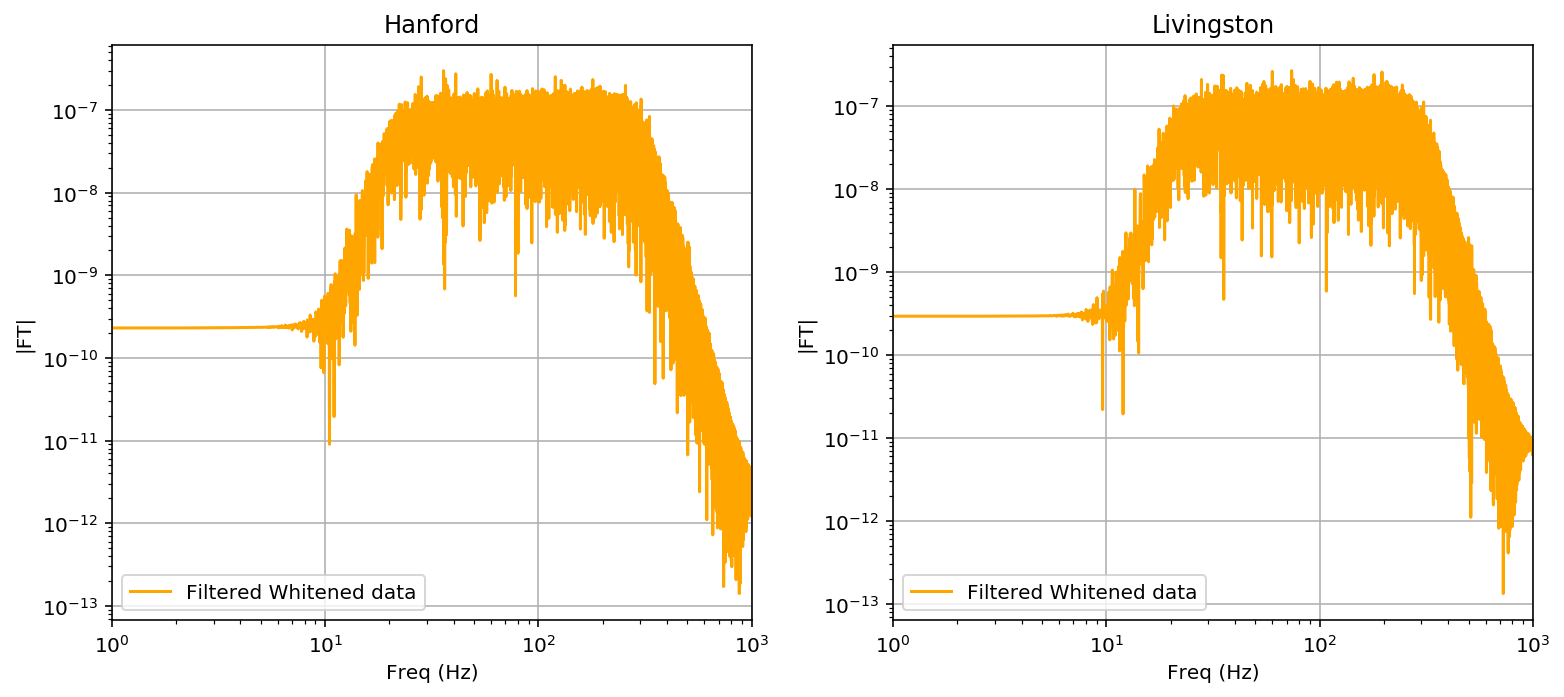

In [54]:
fig, ax = plt.subplots(1, 2,figsize=(11,5))

ax[0].loglog(freqs,dt*np.abs(np.fft.rfft(H1_strain_wh_bd,n=l)),color = "orange",label = "Filtered Whitened data")
ax[0].set_title("Hanford");ax[0].set_xlabel('Freq (Hz)');ax[0].set_ylabel("|FT|")
ax[0].grid();ax[0].legend();ax[0].set_xlim([1,1000])

ax[1].loglog(freqs,dt*np.abs(np.fft.rfft(L1_strain_wh_bd,n=l)),color = "orange",label = "Filtered Whitened data")
ax[1].set_title("Livingston");ax[1].set_xlabel('Freq (Hz)');ax[1].set_ylabel("|FT|")
ax[1].grid();ax[1].legend();ax[1].set_xlim([1,1000])

plt.tight_layout()
plt.show()

$\bullet$ As we can see, the filter has sigificantly suppressed the frequency content outside the theoretically predicted region of interest of $\approx$ 20-300 Hz. 

$\bullet$ Now we can plot the full (32.0 s) time domain waveforms, as well as zoomed plots centered on the time of the event as supplied in the Ligo data.

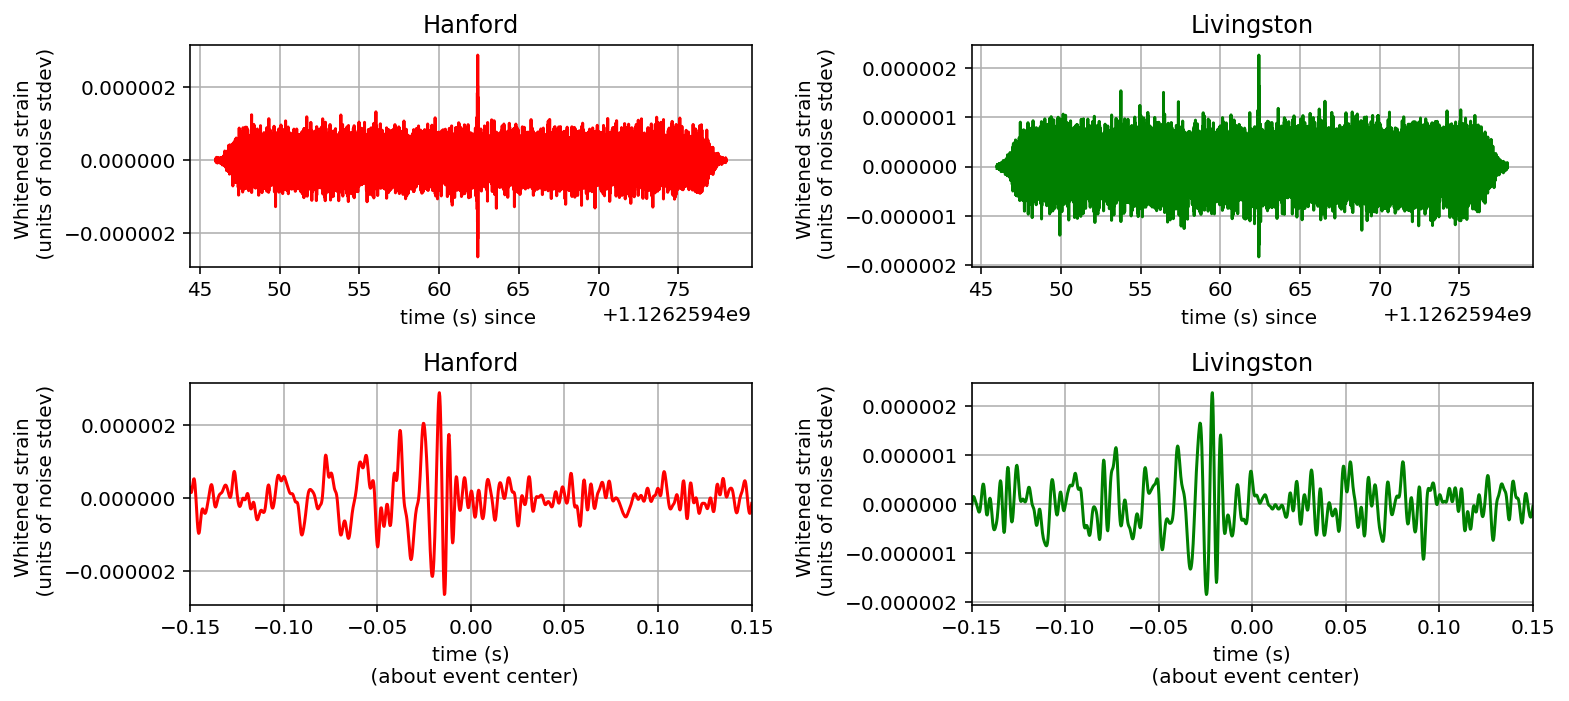

In [71]:
fig, ax = plt.subplots(2, 2,figsize=(11,5))

ax[0,0].plot(time,H1_strain_wh_bd,color='r')
ax[0,0].set_title("Hanford");ax[0,0].set_xlabel('time (s) since ');ax[0,0].set_ylabel("Whitened strain \n (units of noise stdev)")
ax[0,0].grid();ax[0,0].set_xlim(None)

ax[0,1].plot(time,L1_strain_wh_bd,color='g')
ax[0,1].set_title("Livingston");ax[0,1].set_xlabel('time (s) since ');ax[0,1].set_ylabel("Whitened strain \n (units of noise stdev)")
ax[0,1].grid();ax[0,1].set_xlim(None)


ax[1,0].plot(time-tevent,H1_strain_wh_bd,color='r')
ax[1,0].set_title("Hanford");ax[1,0].set_xlabel('time (s)\n (about event center)');ax[1,0].set_ylabel("Whitened strain \n (units of noise stdev)")
ax[1,0].grid();ax[1,0].set_xlim([-0.15,0.15])

ax[1,1].plot(time-tevent,L1_strain_wh_bd,color='g')
ax[1,1].set_title("Livingston");ax[1,1].set_xlabel('time (s)\n (about event center)');ax[1,1].set_ylabel("Whitened strain \n (units of noise stdev)")
ax[1,1].grid();ax[1,1].set_xlim([-0.15,0.15])

plt.tight_layout()
plt.show()

# Matched Filter